# Spectral Bands

In [2]:
import os
import parser as p
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
rootdir = "../../../data.nosync/"

In [4]:
filename = "Dog_1_preictal_segment_0001.mat"
path = rootdir + filename
mat = sio.loadmat(path)
data = p.get_data(mat)
channels = p.get_channels(mat)
sampling_frequency = p.get_sampling_frequency(mat)
t = np.arange(0, np.rint(sampling_frequency).astype(int)) / sampling_frequency

In [5]:
def bandpass_filter(X, fs, low, high, order=2):
    "The bandpass filtered signal."
    nyquist = 0.5 * fs
    low = low/nyquist
    high = high/nyquist
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.lfilter(b, a, X)
    return y

def fourier_transform(X, fs, n):
    ampl = np.abs(rfft(X))
    powr = ampl**2
    freq = rfftfreq(n, 1/fs)
    return ampl, powr, freq

def pib(X,fs,n):
    """
    Computes the power in band for multi-channel input signals.
    
    Power in band is the natural log sum of power in each of the six
    frequency bands.
    
    Returns: power_total, power_delta, power_theta, power_alpha, power_beta, power_low_gamma, power_high_gamma
    """
    ampl, powr, freq = fourier_transform(X, fs, n)
    power_total = np.sum(powr)
    
    delta_EEG = bandpass_filter(X, fs, low=0.1, high=4)
    _, powr, _ = fourier_transform(delta_EEG, fs, n)
    power_delta = np.sum(powr)
    
    theta_EEG = bandpass_filter(X, fs, low=4, high=8)
    _, powr, _ = fourier_transform(theta_EEG, fs, n)
    power_theta = np.sum(powr)
    
    alpha_EEG = bandpass_filter(X, fs, low=8, high=12)
    _, powr, _ = fourier_transform(alpha_EEG, fs, n)
    power_alpha = np.sum(powr)
    
    beta_EEG = bandpass_filter(X, fs, low=12, high=30)
    _, powr, _ = fourier_transform(beta_EEG, fs, n)
    power_beta = np.sum(powr)
    
    low_gamma_EEG = bandpass_filter(X, fs, low=30, high=70)
    _, powr, _ = fourier_transform(low_gamma_EEG, fs, n)
    power_low_gamma = np.sum(powr)
    
    high_gamma_EEG = bandpass_filter(X, fs, low=70, high=180)
    _, powr, _ = fourier_transform(high_gamma_EEG, fs, n)
    power_high_gamma = np.sum(powr)
    
    return power_total, power_delta, power_theta, power_alpha, power_beta, power_low_gamma, power_high_gamma

In [6]:
def plot_spectral_amplitude(x, sampling_frequency, title):
    delta_EEG = bandpass_filter(x, sampling_frequency, low=0.1, high=4)
    ampl, powr, freq = fourier_transform(delta_EEG, sampling_frequency, n)
    d_amp = np.mean(ampl)
#     print(d_amp)

    theta_EEG = bandpass_filter(x, sampling_frequency, low=4, high=8)
    ampl, powr, freq = fourier_transform(theta_EEG, sampling_frequency, n)
    t_amp = np.mean(ampl)
#     print(t_amp)

    alpha_EEG = bandpass_filter(x, sampling_frequency, low=8, high=12)
    ampl, powr, freq = fourier_transform(alpha_EEG, sampling_frequency, n)
    a_amp = np.mean(ampl)
#     print(a_amp)

    beta_EEG = bandpass_filter(x, sampling_frequency, low=12, high=30)
    ampl, powr, freq = fourier_transform(beta_EEG, sampling_frequency, n)
    b_amp = np.mean(ampl)
#     print(b_amp)

    low_gamma_EEG = bandpass_filter(x, sampling_frequency, low=30, high=70)
    ampl, powr, freq = fourier_transform(low_gamma_EEG, sampling_frequency, n)
    lg_amp = np.mean(ampl)
#     print(lg_amp)

    high_gamma_EEG = bandpass_filter(x, sampling_frequency, low=70, high=180)
    ampl, powr, freq = fourier_transform(high_gamma_EEG, sampling_frequency, n)
    hg_amp = np.mean(ampl)
#     print(hg_amp)

    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma'], [d_amp, t_amp, a_amp, b_amp, lg_amp, hg_amp])
    ax.set_title(title)
    ax.set_ylabel('Mean Band Amplitude')
    ax.set_xlabel('Spectral Band')
    ax.set_ylim([0,1000])
    fig.tight_layout()
#     print('---')

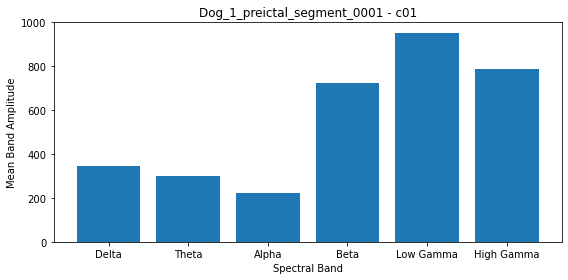

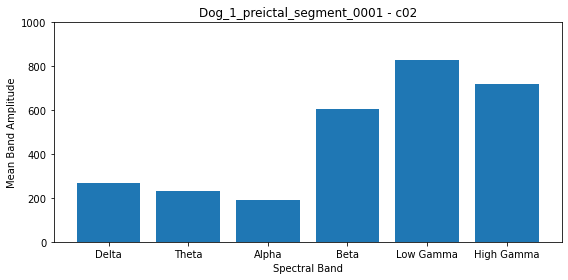

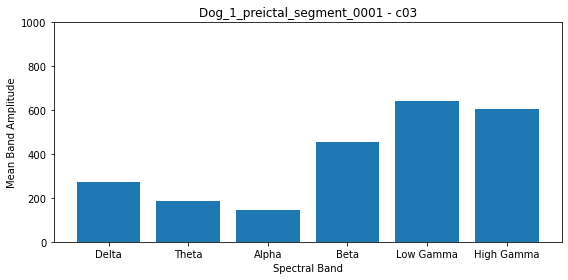

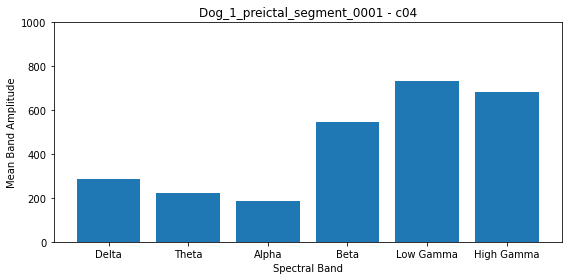

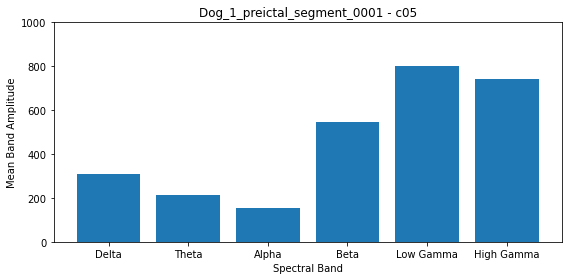

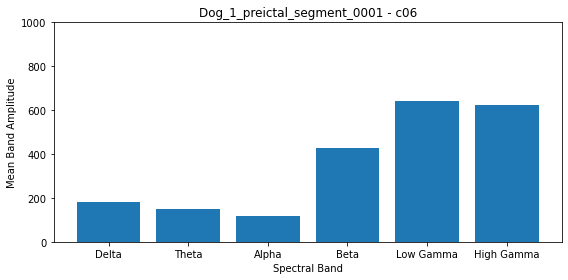

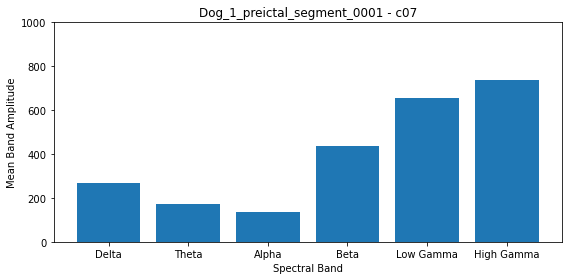

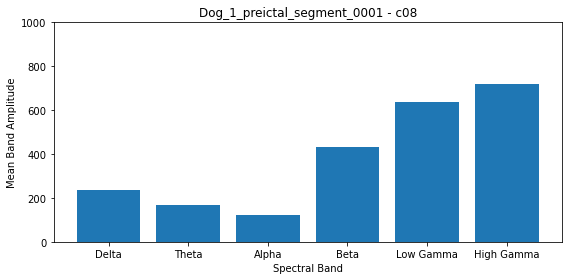

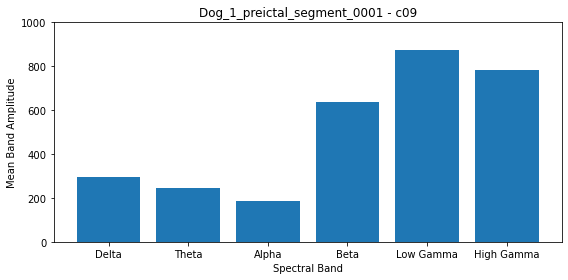

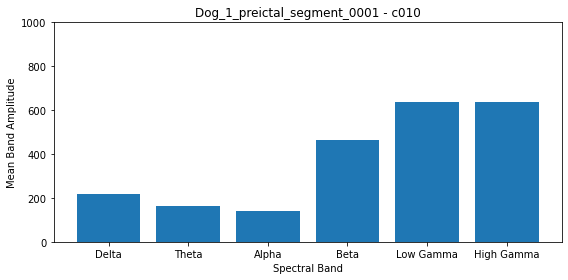

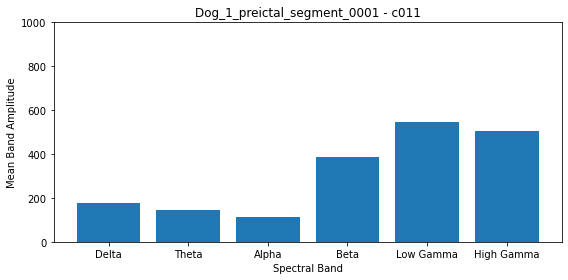

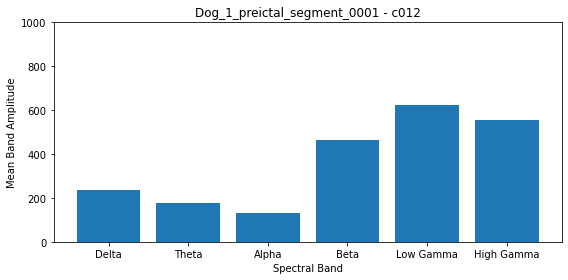

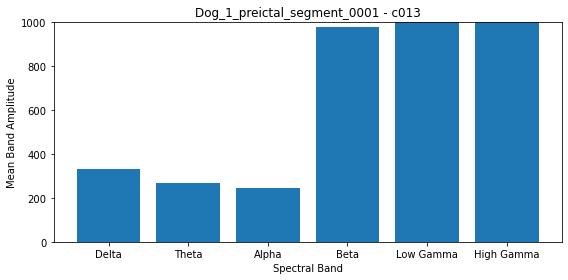

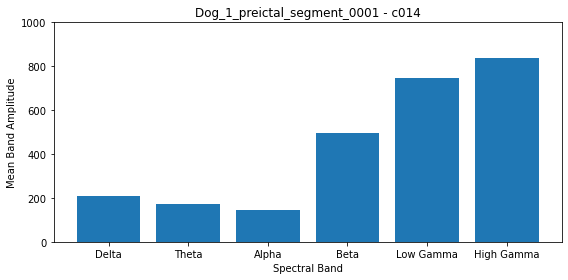

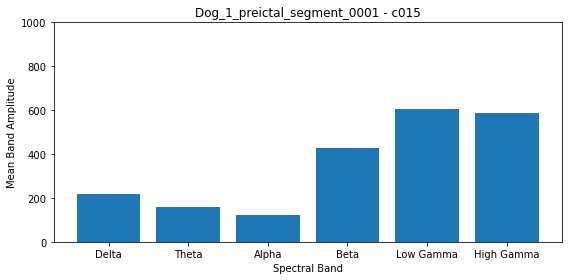

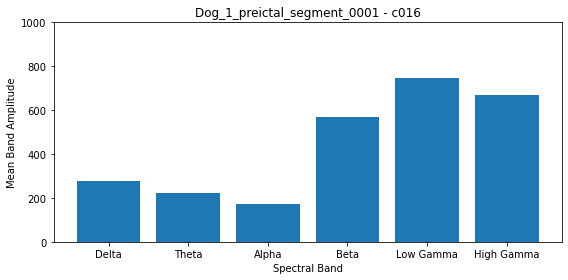

In [138]:
# mean spectral band of preictal (first 60s of each channel)
n = np.rint(sampling_frequency).astype(int) * 60
for i in range(16):
    x = data[i,0:n]
    plot_spectral_amplitude(x, sampling_frequency, 'Dog_1_preictal_segment_0001 - c0'+str(i+1))

Taking a one min sample from each channel and plotting the mean spectral amplitude above shows that the preictal period is dominated by the gamma band. For comparison, we show the same analysis for an interictal 1 min sample.

In [139]:
filename = "Dog_1_interictal_segment_0001.mat"
path = rootdir + filename
mat = sio.loadmat(path)
data = p.get_data(mat)
channels = p.get_channels(mat)
sampling_frequency = p.get_sampling_frequency(mat)
t = np.arange(0, np.rint(sampling_frequency).astype(int)) / sampling_frequency

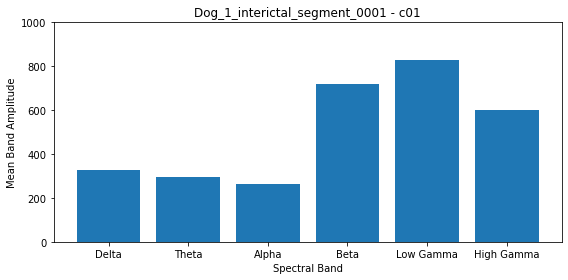

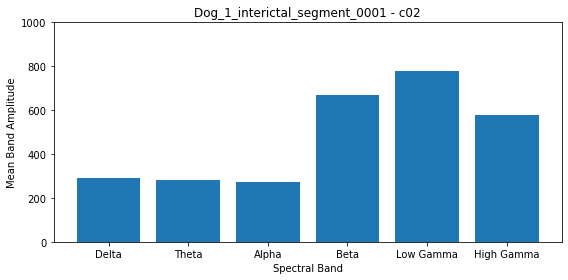

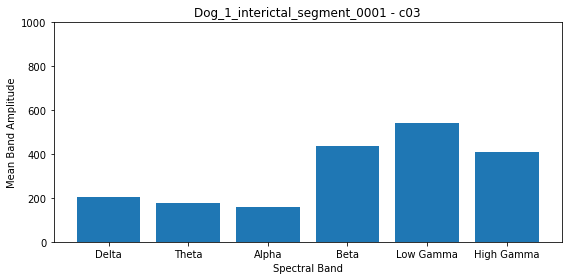

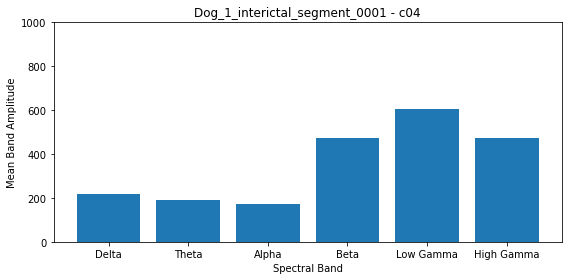

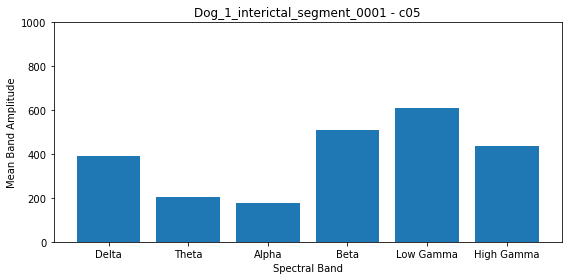

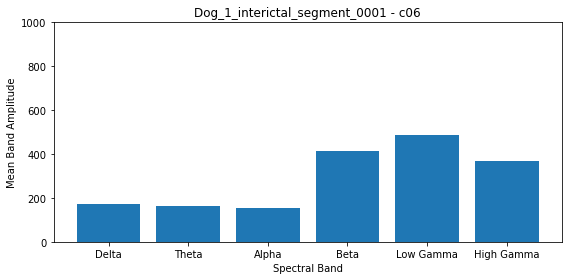

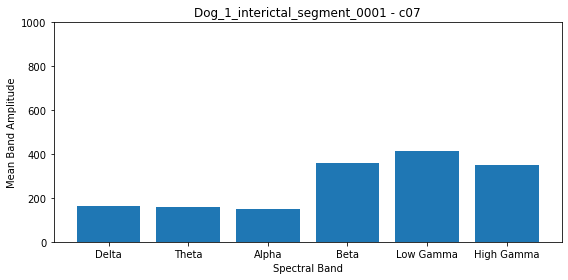

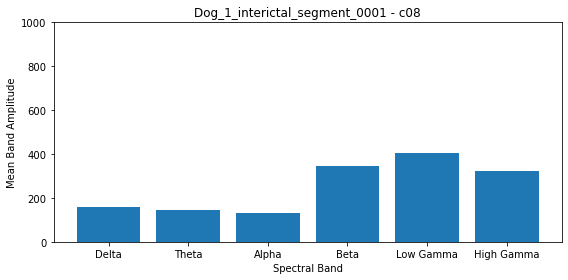

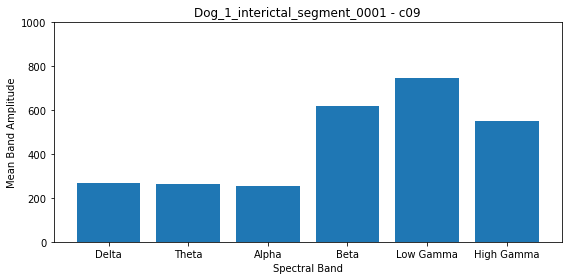

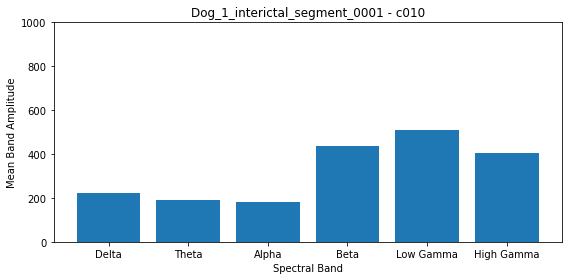

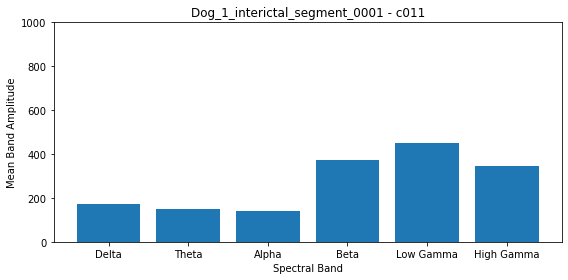

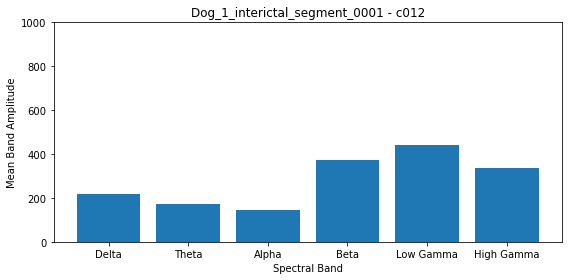

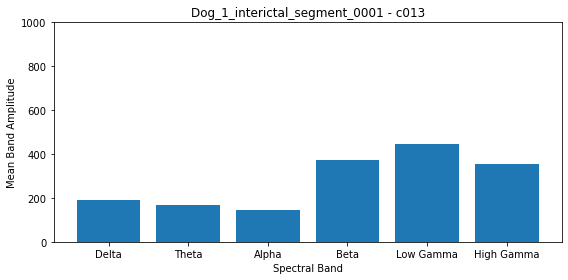

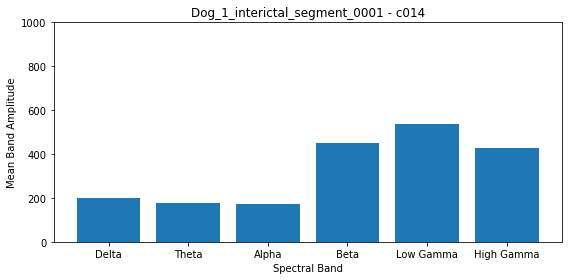

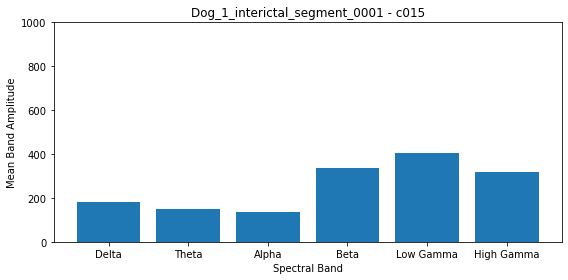

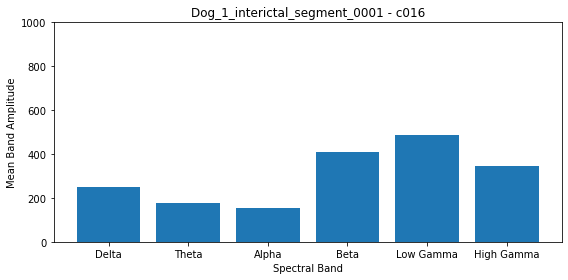

In [140]:
# mean spectral band of interictal (first 60s of each channel)
n = np.rint(sampling_frequency).astype(int) * 60
for i in range(16):
    x = data[i,0:n]
    plot_spectral_amplitude(x, sampling_frequency, 'Dog_1_interictal_segment_0001 - c0'+str(i+1))

(1, 215767, 16, 24000)

In [161]:
n = np.rint(sampling_frequency).astype(int) * 60
v = np.lib.stride_tricks.sliding_window_view(data, (16,n))     # PIB of 60s block windows
pib_features = np.zeros((215767, 7))
for i in tqdm(range(len(np.squeeze(v)))):
    EEG = np.squeeze(v)
    n = np.rint(sampling_frequency).astype(int) * 60
    pib_tup = pib(data[:,0:n], sampling_frequency, n)
    pib_arr = np.asarray(pib_tup)
    pib_feature = np.log10(pib_arr)
    pib_features[i,:] = pib_feature

100%|██████████| 215767/215767 [5:04:17<00:00, 11.82it/s]   


In [162]:
import h5py

# save to disk
filename = '/Volumes/My Passport/AI_Research/save_mat/Dog_1_interictal_segment_0001_pib_features.h5'
f = h5py.File(filename, 'w')
f.create_dataset("Dog_1_interictal_segment_0001_pib_features", data=pib_features)
f.close()

In [151]:
pib_features.shape

(215767, 7)

In [146]:
np.random.seed(32)
x = np.random.randn(8,4)
x

array([[-0.34889445,  0.98370343,  0.58092283,  0.07028444],
       [ 0.77753268,  0.58195875,  1.47179053,  1.66318101],
       [-0.26117712, -0.68867681, -0.69492326,  1.94042346],
       [ 1.80541519,  0.45631385, -0.57481204,  0.1141805 ],
       [ 1.51358077,  0.35113184, -0.08893321,  0.91695423],
       [ 0.50564513, -0.81527111,  0.38915095, -0.42496247],
       [ 0.03962315, -0.52796392, -0.51030368, -0.88828515],
       [ 1.08762473,  0.67339226, -1.06731704,  1.21804998]])

In [147]:
x[0,:]

array([-0.34889445,  0.98370343,  0.58092283,  0.07028444])

In [52]:
np.lib.stride_tricks.sliding_window_view(x, (8,2)).shape

(1, 3, 8, 2)

In [38]:
x = data[15,]
n = np.rint(sampling_frequency).astype(int)*60
view = np.lib.stride_tricks.sliding_window_view(x, n, axis=0)
view.shape

(215767, 24000)

ValueError: not enough values to unpack (expected 2, got 1)

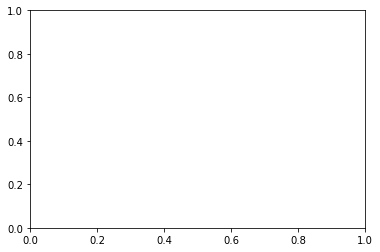

In [41]:
for i in range(len(view)):
    EEG = view[i,] # 1 min block of EEG
    fourier_ampl = np.abs(rfft(EEG))
    fourier_powr = fourier_ampl**2
    fourier_freq = rfftfreq(n, 1/sampling_frequency)
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(t, fourier_freq, np.log10(fourier_powr), shading='gouraud')
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Frequency, Hz')
    cbar = fig.colorbar(mesh)
    cbar.ax.set_ylabel('$\log_{10}$ Power')

In [27]:
x = np.arange(0,10)
n = 2
view = np.lib.stride_tricks.sliding_window_view(x, n, axis=0)
view.shape

(9, 2)

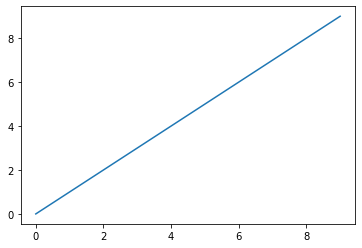

In [28]:
plt.plot(x)

In [30]:
len(view)

9

In [31]:
view[0,].shape

(2,)

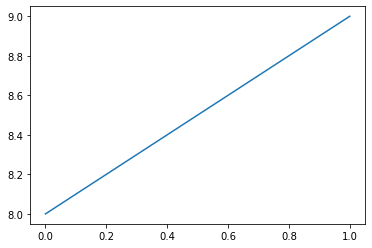

In [36]:
plt.plot(view[8,])